In [1]:
%matplotlib inline

In [2]:
import numpy as np # Who does not use Numpy?
import re, sys, os, math
from scipy import signal

import cma
from skimage.util import compare_images
from tifffile import imsave
from sklearn.metrics import mean_squared_error

import matplotlib
# old_backend =  matplotlib.get_backend() 
# matplotlib.use("Agg")  # Prevent showing stuff

from matplotlib.cm import get_cmap
import matplotlib.pyplot as plt # Plotting
from matplotlib.colors import LogNorm # Look up table
from matplotlib.colors import PowerNorm # Look up table
import matplotlib.colors as mcolors

font = {'family' : 'serif',
        #'weight' : 'bold',
         'size'   : 22
       }
matplotlib.rc('font', **font)
matplotlib.rc('text', usetex=True)

import SimpleITK as sitk
import spekpy as sp
import gvxrPython3 as gvxr

Read the DICOM file

In [3]:
reader = sitk.ImageFileReader()
reader.SetImageIO("GDCMImageIO")
reader.SetFileName("data/DX000000")
reader.LoadPrivateTagsOn()
reader.ReadImageInformation()    
volume = reader.Execute()
real_image = sitk.GetArrayFromImage(volume)[0]

In [4]:
# meta_data_keys = volume.GetMetaDataKeys()

# print("DICOM fields:")
# for key in meta_data_keys:
#     print(key, volume.GetMetaData(key))

In [5]:
# def cleanTags(raw_string):
#     regular_expression = re.compile('<.*?>')
#     clean_text = re.sub(regular_expression, '', raw_string)
#     return clean_text


In [6]:



# field = volume.GetMetaData("0033|1022")

# for item in field.split("\n"):
#     if "KV" in item:
#         kv = float(cleanTags(item))
        

# print(kv)


In [7]:
spacing = volume.GetSpacing()[0:2]
size = volume.GetSize()[0:2]

In [8]:
kVp = float(volume.GetMetaData("0018|0060"))
print("Peak kilo voltage output of the x-ray generator used: ", kVp)

Peak kilo voltage output of the x-ray generator used:  89.9


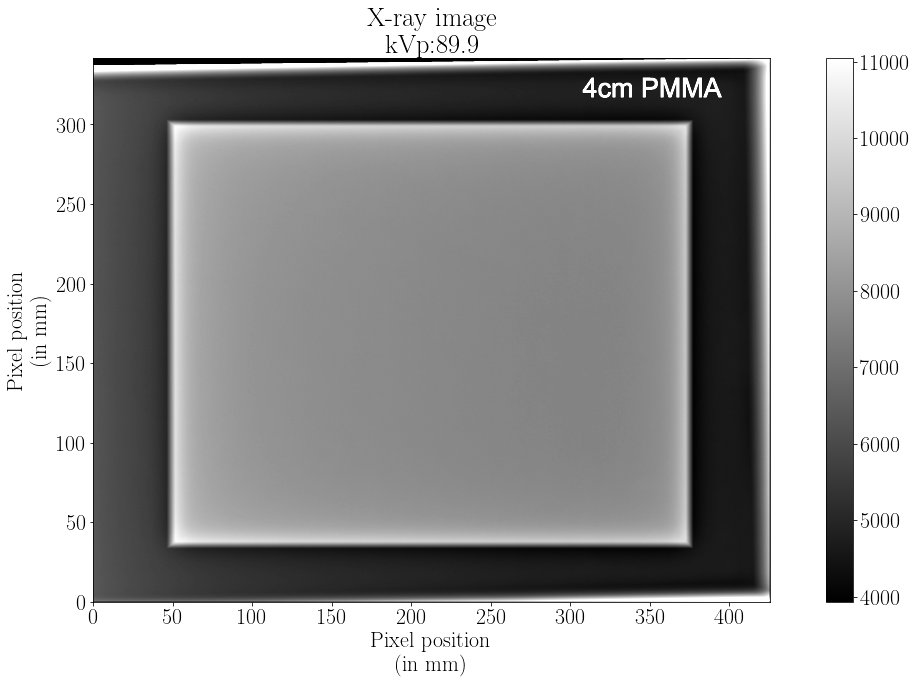

In [9]:
plt.figure(figsize= (20,10))
xrange=range(real_image.shape[1])
yrange=range(real_image.shape[0])

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")
plt.title("X-ray image\nkVp:" + str(kVp))
plt.imshow(real_image, cmap="gray", 
           vmin=3934, vmax = 11045,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='vertical')

In [ ]:
source_detector_distance = float(volume.GetMetaData("0018|1110"))
print("Distance Source to Detector: ", kVp)

In [ ]:
source_object_distance = float(volume.GetMetaData("0018|1111"))
print("Distance Source to Patient: ", source_object_distance)

In [10]:
window_size =  [800, 450]
source_position = [0.0, 0.0, 100.0, "cm"]
detector_position = [0.0, 0.0, -125.0, "cm"]
detector_up = [0, 1, 0]

In [11]:
# Create an OpenGL context
print("Create an OpenGL context:",
    str(window_size[0]) + "x" + str(window_size[1])
);
gvxr.createOpenGLContext();
gvxr.setWindowSize(
    window_size[0],
    window_size[1]
);


Create an OpenGL context: 800x450


In [12]:
def createBlock(x, y, z, w, h, r):
    # Remove all the geometries from the whole scenegraph
    gvxr.removePolygonMeshesFromSceneGraph()

    # Make a cube
    gvxr.makeCube("PMMA block", 1.0, "mm")

    # Translation vector
    gvxr.translateNode("PMMA block", x, y, z, "cm")

    # Rotation angle
    gvxr.rotateNode("PMMA block", r, 0, 0, 1)

    # Scaling factors
    gvxr.scaleNode("PMMA block", w, h, 40);

    # Apply the transformation matrix so that we can save the corresponding STL file
    gvxr.applyCurrentLocalTransformation("PMMA block");

    # Set the matrix's material properties
    gvxr.setCompound("PMMA block", "C5O2H8")
    gvxr.setDensity("PMMA block", 1.18, "g/cm3")

    # Add the matrix to the X-ray renderer
    gvxr.addPolygonMeshAsInnerSurface("PMMA block")

In [13]:
x = y = 0
z = -110
w = 330
h = 270
r = 0
createBlock(x, y, z, w, h, r)

In [14]:
# Set up the beam
print("Set up the beam")
print("\tSource position:", source_position)
gvxr.setSourcePosition(
    source_position[0],
    source_position[1],
    source_position[2],
    source_position[3]
);

gvxr.usePointSource();

focal_spot_size = volume.GetMetaData("0018|1413")
# gvxr.setFocalSpot(focal_spot_size, focal_spot_size, focal_spot_size, "mm");
print("size of focal spot (in mm):", focal_spot_size)

Set up the beam
	Source position: [0.0, 0.0, 100.0, 'cm']
size of focal spot (in mm): 11.653


# Get the spectrum from the DICOM file

In [15]:
spectrum = {};

s = sp.Spek(kvp=kVp)
# s.filter(filter_material, filter_thickness_in_mm) # Filter by 4 mm of Al
unit = "keV"
k, f = s.get_spectrum(edges=True) # Get the spectrum

min_energy = sys.float_info.max
max_energy = -sys.float_info.max

for energy, count in zip(k, f):
    count = round(count)

    if count > 0:

        max_energy = max(max_energy, energy)
        min_energy = min(min_energy, energy)

        if energy in spectrum.keys():
            spectrum[energy] += count
        else:
            spectrum[energy] = count

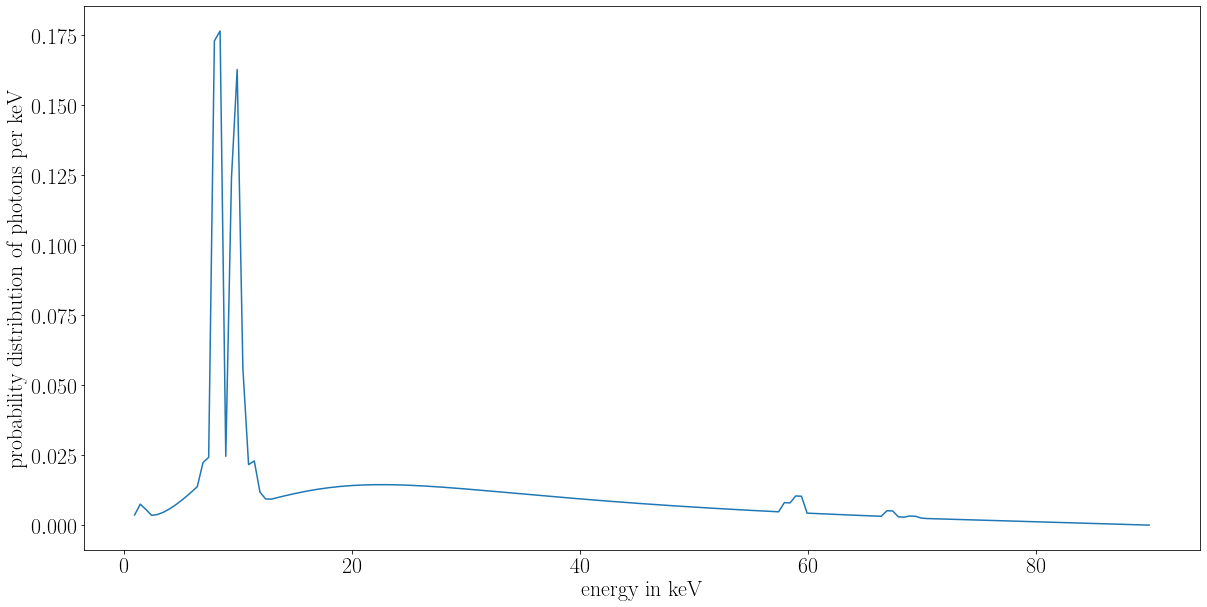

In [16]:
# get the integral nb of photons
nbphotons=0.
energy1 = -1.
energy2 = -1.

for energy in spectrum.keys():
    
    if energy1<0:
        energy1 = float(energy)
    elif energy2<0:
        energy2 = float(energy)
    nbphotons += float(spectrum[energy])
sampling = (energy2-energy1)

# get spectrum
data = []
for energy in spectrum.keys():
    source = [float(energy),float(spectrum[energy])/(nbphotons*sampling)]
    data.append(source)

# plot spectrum
plt.figure(figsize= (20,10))

data_array = np.array(data)

energies, counts = data_array.T
plt.plot(energies, counts)
plt.xlabel('energy in keV')
plt.ylabel('probability distribution of photons per keV')

plt.savefig("spectrum.pdf")

In [17]:
number_of_energy_bins = 25
count_set = signal.resample(counts, number_of_energy_bins)
energy_set = np.linspace(energies.min(), energies.max(), number_of_energy_bins, endpoint=True)

In [18]:
# for energy in spectrum.keys():
#     count = spectrum[energy]
#     gvxr.addEnergyBinToSpectrum(energy, unit, count);

for energy, count in zip(energy_set, count_set):
    gvxr.addEnergyBinToSpectrum(energy, unit, count);

In [19]:
# Set up the detector
print("Set up the detector");
print("\tDetector position:", detector_position)
gvxr.setDetectorPosition(
    detector_position[0],
    detector_position[1],
    detector_position[2],
    detector_position[3]
);

print("\tDetector up vector:", detector_up)
gvxr.setDetectorUpVector(
    detector_up[0],
    detector_up[1],
    detector_up[2]
);

Set up the detector
	Detector position: [0.0, 0.0, -125.0, 'cm']
	Detector up vector: [0, 1, 0]


In [20]:
print("\tDetector number of pixels:", size)
gvxr.setDetectorNumberOfPixels(
    size[0],
    size[1]
);

print("\tPixel spacing:", spacing)
gvxr.setDetectorPixelSize(
    spacing[0],
    spacing[1],
    "mm"
);

	Detector number of pixels: (3040, 2442)
	Pixel spacing: (0.14, 0.14)


In [21]:
gvxr.displayScene()

gvxr.useLighing()
gvxr.useWireframe()
gvxr.setSceneRotationMatrix([-0.05354100465774536, 0.10387273132801056, -0.993146538734436, 0.0, 0.046926096081733704, 0.9937328696250916, 0.10140645503997803, 0.0, 0.9974606037139893, -0.04117576405405998, -0.05807636305689812, 0.0, 0.0, 0.0, 0.0, 1.0])
gvxr.setZoom(2309.6787109375)

gvxr.displayScene()

In [22]:
screenshot = gvxr.takeScreenshot()

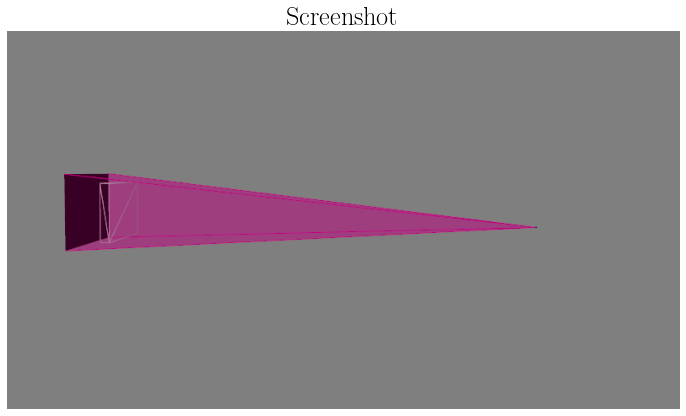

In [23]:
plt.figure(figsize= (10,10))
plt.title("Screenshot")
plt.imshow(screenshot)
plt.axis('off')

plt.tight_layout()

plt.savefig('plots/screenshot-beam-off.pdf')
plt.savefig('plots/screenshot-beam-off.png')

# Optimise the size and position of the block

In [28]:
def standardisation(image):
    return (image - image.mean()) / image.std();

In [29]:
def zncc(i1, i2):
    return (np.mean(np.multiply(i1, i2))) / 2.0;

In [30]:
def objectiveFunction(parameters):
    
    global best_fitness
    global best_fitness_id
    global fitness_function_call_id
    global evolution_zncc
    
    # Retrieve the parameters
    x, y, z, w, h, r = parameters
    
    # Update the block geometry
    createBlock(x, y, z, w, h, r)
    
    # Compute an X-ray image
    x_ray_image = np.array(gvxr.computeXRayImage())
    
    # Compute the negative image as it is the case for the real image
    x_ray_image *= -1.
    
    # Zero-mean, unit-variance normalistion
    x_ray_image = standardisation(x_ray_image)
    
    # Return the objective
    objective = math.sqrt(mean_squared_error(real_image, x_ray_image))

    # The block below is not necessary for the registration.
    # It is used to save the data to create animations.
    if best_fitness > objective:
        
        gvxr.displayScene()
        screenshot = (255 * np.array(gvxr.takeScreenshot())).astype(np.uint8)

        gvxr.saveSTLfile("PMMA block", "outputs/PMMA_block_" + str(best_fitness_id) + ".stl")
        np.savetxt("outputs/PMMA_block_" + str(best_fitness_id) + ".dat", [x, y, z, w, h, r], header='x,y,z,w,h,r')
        imsave("outputs/xray_" + str(best_fitness_id) + ".tif", x_ray_image.astype(np.single))
        imsave("outputs/screenshot_" + str(best_fitness_id) + ".tif", screenshot)
    
        zncc_value = zncc(real_image, x_ray_image)
        evolution_zncc.append([fitness_function_call_id, zncc_value])
        
        best_fitness = objective
        best_fitness_id += 1
    
    fitness_function_call_id += 1
    
    return objective

In [31]:
# Zero-mean, unit-variance normalistion
real_image = standardisation(real_image)

In [32]:
# The registration has already been performed. Load the results.
if os.path.isfile("outputs/PMMA_block.dat") and os.path.isfile("outputs/evolution_zncc.dat"):
    
    temp = np.loadtxt("outputs/PMMA_block.dat")
    x = temp[0]
    y = temp[1]
    z = temp[2]
    w = temp[3]
    h = temp[4]
    r = temp[5]
    
    # Update the block geometry
    createBlock(x, y, z, w, h, r)

    evolution_zncc = np.loadtxt("outputs/PMMA_block.dat")

else:
    # Optimise
    opts = cma.CMAOptions()
    opts.set('tolfun', 1e-2)
    opts['tolx'] = 1e-2
    opts['bounds'] = [[-10, -10, detector_position[2] + 4, 320, 260, -90],
                      [10, 10, source_position[2] - 4, 340, 280, 90]]
    opts['CMA_stds'] = []

    for min_val, max_val in zip(opts['bounds'][0], opts['bounds'][1]):
        opts['CMA_stds'].append(abs(max_val - min_val) * 0.05)

    best_fitness = sys.float_info.max;
    best_fitness_id = 0;
    fitness_function_call_id = 0
    evolution_zncc = []

    # Optimise
    es = cma.CMAEvolutionStrategy([x, y, z, w, h, r], 0.5, opts)
    es.optimize(objectiveFunction)

    # Save the parameters
    x, y, z, w, h, r = es.result.xbest
    np.savetxt("outputs/PMMA_block.dat", [x, y, z, w, h, r], header='x,y,z,w,h,r')

    # Update the block geometry
    createBlock(x, y, z, w, h, r)
    gvxr.saveSTLfile("PMMA block", "outputs/PMMA_block_" + str(best_fitness_id) + ".stl")

    evolution_zncc = np.array(evolution_zncc)
    np.savetxt("outputs/evolution_zncc.dat", evolution_zncc, header='t,ZNCC')

    # Release memory
    del es;

(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=728461, Tue Sep 14 12:44:28 2021)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 9.354463958190156e-01 1.0e+00 4.88e-01  5e-01  6e+00 0:19.6
    2     18 9.288701527199572e-01 1.3e+00 4.53e-01  4e-01  5e+00 0:35.0
    3     27 9.279737257709426e-01 1.2e+00 4.65e-01  4e-01  5e+00 0:46.1
    4     36 9.047682974052406e-01 1.4e+00 4.57e-01  4e-01  5e+00 0:57.7
    5     45 9.112186395651103e-01 1.5e+00 4.85e-01  4e-01  6e+00 1:05.1
    6     54 8.899606496230531e-01 1.8e+00 4.61e-01  4e-01  6e+00 1:20.0
    7     63 9.186711539402073e-01 1.9e+00 4.68e-01  4e-01  6e+00 1:27.5
    8     72 9.020032664325306e-01 2.0e+00 4.54e-01  4e-01  6e+00 1:34.8
    9     81 8.870907784902763e-01 1.9e+00 3.72e-01  3e-01  4e+00 1:45.9
   11     99 8.846018294696473e-01 1.8e+00 3.71e-01  3e-01  4e+00 2:04.9
   13    117 8.972645492263411e-01 1.9e+00 3.39e-01  3e-01  3e+00 2:20.0
   14    126 8.821418144441869e-01 

In [33]:
# Compute an X-ray image
x_ray_image = np.array(gvxr.computeXRayImage())

gvxr.displayScene()

# Compute the negative image as it is the case for the real image
x_ray_image *= -1.

# Zero-mean, unit-variance normalistion
x_ray_image = standardisation(x_ray_image)

Text(0, 0.5, 'ZNCC\n(in \\%)')

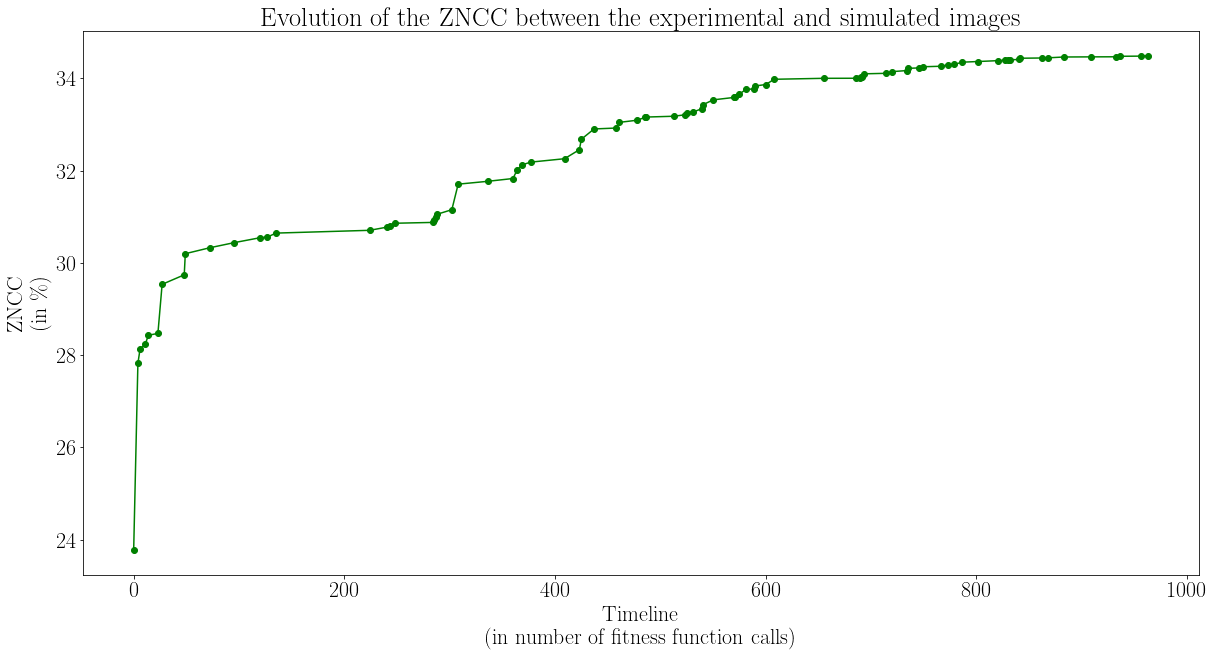

In [38]:
plt.figure(figsize= (20,10))
plt.title("Evolution of the ZNCC between the experimental and simulated images")
plt.plot(evolution_zncc[:,0], 100.0 * evolution_zncc[:,1], "go-")
plt.xlabel("Timeline\n(in number of fitness function calls)")
plt.ylabel("ZNCC\n(in \%)")

In [39]:
gvxr.renderLoop()


In [40]:
# void setZoom(float aZoomValue);
print(gvxr.getZoom())
print(gvxr.getSceneRotationMatrix())

2309.6787109375
(-0.05354100465774536, 0.10387273132801056, -0.993146538734436, 0.0, 0.046926096081733704, 0.9937328696250916, 0.10140645503997803, 0.0, 0.9974606037139893, -0.04117576405405998, -0.05807636305689812, 0.0, 0.0, 0.0, 0.0, 1.0)


In [41]:
comp_equalized = compare_images(real_image, x_ray_image, method='checkerboard');

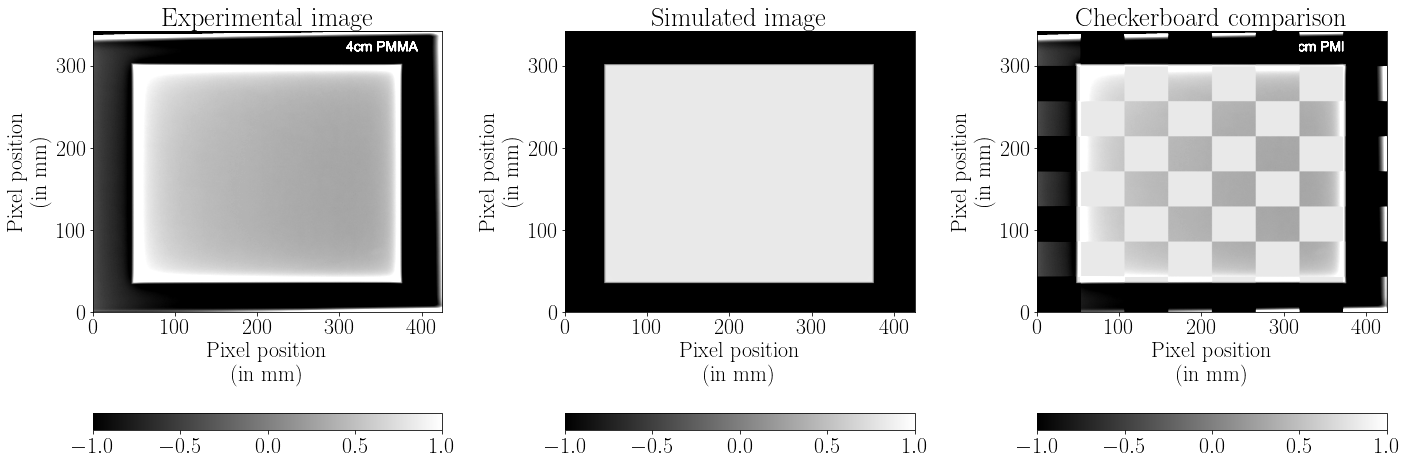

In [42]:
plt.figure(figsize= (20,10))

# plt.suptitle("Image simulated using gVirtualXRay without the energy response of the detector", y=1.02)

plt.subplot(131)
plt.imshow(real_image, cmap="gray", vmin=-1, vmax=1,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='horizontal')
plt.title("Experimental image")
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")

plt.subplot(132)
plt.imshow(x_ray_image, cmap="gray", vmin=-1, vmax=1,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='horizontal')
plt.title("Simulated image")
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")

plt.subplot(133)
plt.imshow(comp_equalized, cmap="gray", vmin=-1, vmax=1,
           extent=[0,(real_image.shape[1]-1)*spacing[0],0,(real_image.shape[0]-1)*spacing[1]])
plt.colorbar(orientation='horizontal')
plt.title("Checkerboard comparison")
plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Pixel position\n(in mm)")

plt.tight_layout()

Text(0, 0.5, 'Relative intensity')

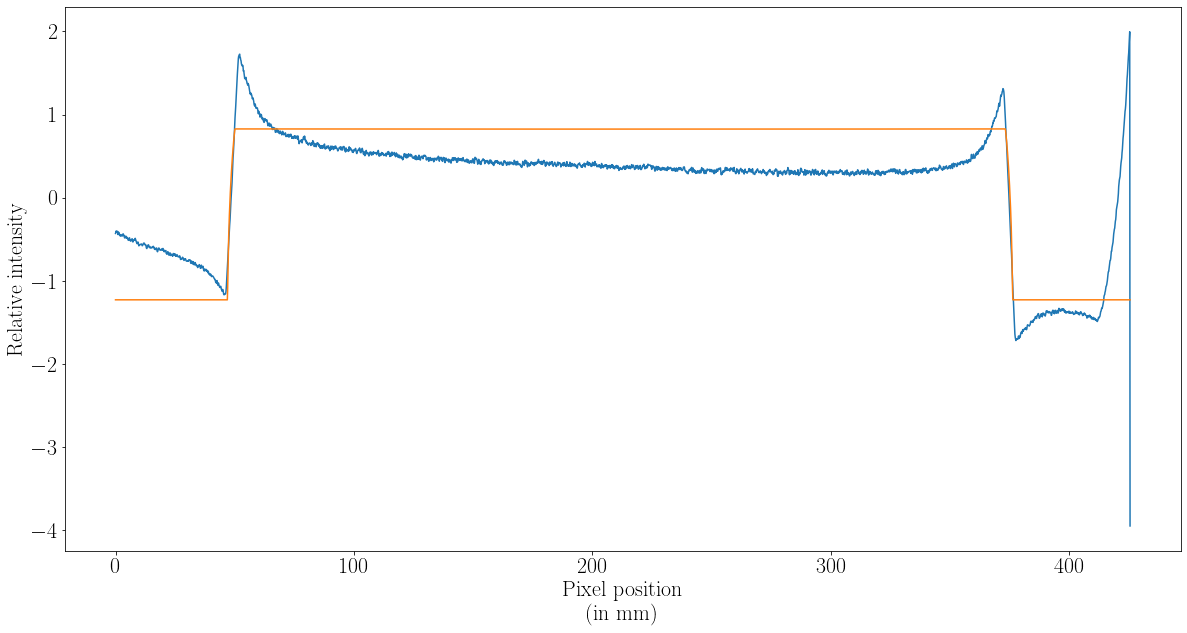

In [43]:
horizontal_profile_real_image = real_image[real_image.shape[1] // 2]
horizontal_profile_simulated_image = x_ray_image[x_ray_image.shape[1] // 2]

plt.figure(figsize= (20,10))

x_val = np.linspace(0.0,
                    spacing[0] * real_image.shape[1],
                    real_image.shape[1], endpoint=True)

plt.plot(x_val, horizontal_profile_real_image)
plt.plot(x_val, horizontal_profile_simulated_image)

plt.xlabel("Pixel position\n(in mm)")
plt.ylabel("Relative intensity")

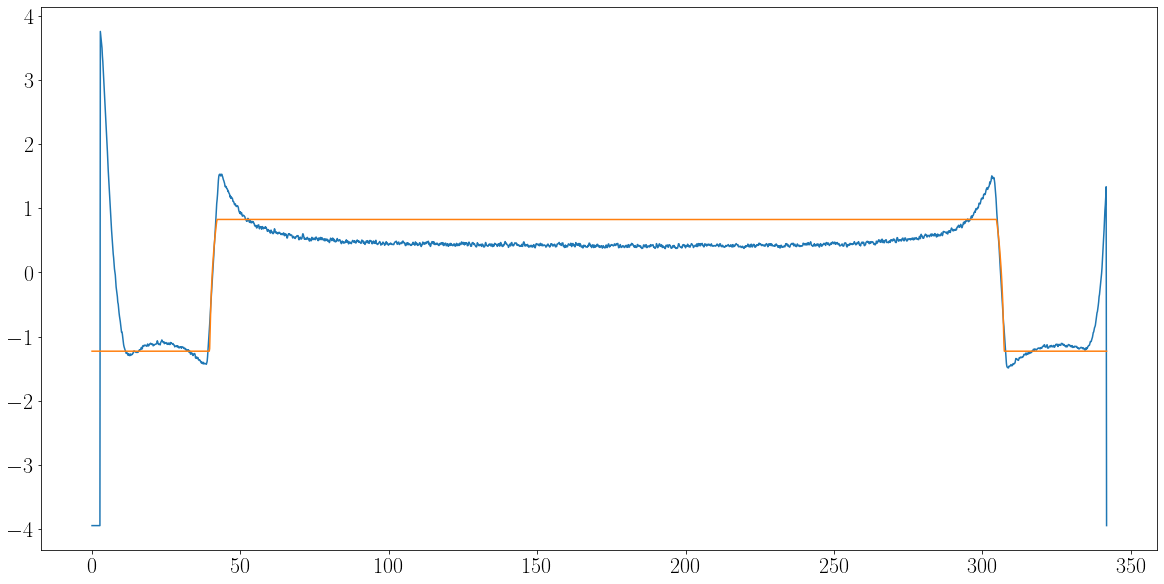

In [44]:
vertical_profile_real_image = real_image[:,real_image.shape[0] // 2]
vertical_profile_simulated_image = x_ray_image[:,x_ray_image.shape[0] // 2]

plt.figure(figsize= (20,10))

x_val = np.linspace(0.0,
                    spacing[1] * real_image.shape[0],
                    real_image.shape[0], endpoint=True)

plt.plot(x_val, vertical_profile_real_image)
plt.plot(x_val, vertical_profile_simulated_image)